In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Logistic regression functions
def F(z):
    r = 1/(1+np.exp(-z))
    return r

def logistic_reg(X,d,max_itr=1000):
    ## Iteration params
    err = 10
    eta = .01
    beta = np.zeros(X.shape[1])
    itr = 0
    eps = 1e-5
    ## Gradient descent
    while err > eps and itr < max_itr :
        latent = X @ beta
        F_0 = F(latent)
        F_1 = 1 - F_0
        gr = X.T @ ( F_1 - d  )/len(d)
        if itr>0: # Subsequent step size
            num = np.abs( np.inner(beta - beta_m1, gr - gr_m1) )
            den = np.sum( (gr-gr_m1)**2 )
            eta = num/den
        beta_p1 = beta + eta*gr
        err = np.sqrt(np.sum(gr**2))
        itr = itr+1
        beta_m1 = np.copy(beta)
        beta = np.copy(beta_p1)
        gr_m1 = np.copy(gr)
    residual = latent + (F_1 -d)/( F_0*F_1)
    print(f"Final error for iteration {itr} is {err}")
    return beta



[[ 1.70795553  1.93920137 -0.18591416]
 [ 1.93920137  4.10712387 -0.10900542]
 [-0.18591416 -0.10900542  2.39740658]]


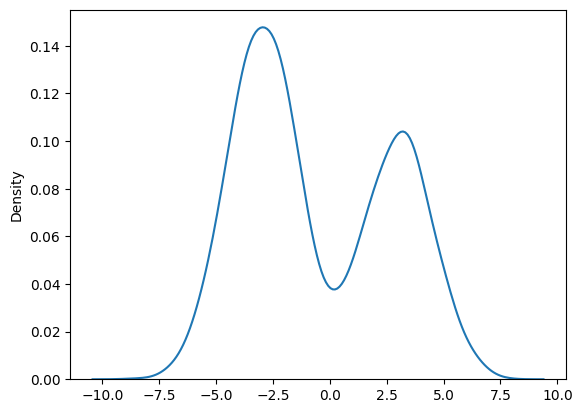

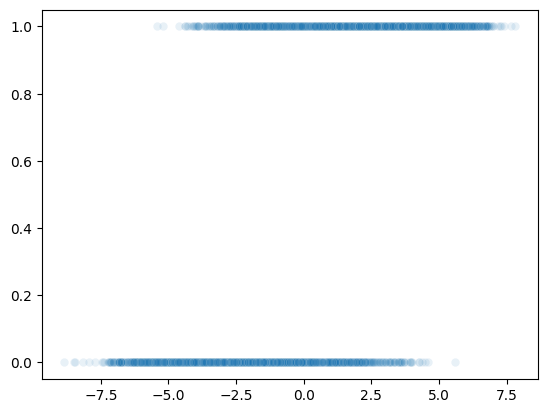

,d,x0,x1,x2,x3,g
d,1.000000,NaN,0.114595,0.218181,0.036141,0.805919
x0,NaN,NaN,NaN,NaN,NaN,NaN
x1,0.114595,NaN,1.000000,0.729171,-0.101119,0.004875
x2,0.218181,NaN,0.729171,1.000000,-0.043066,0.015841
x3,0.036141,NaN,-0.101119,-0.043066,1.000000,-0.005386
g,0.805919,NaN,0.004875,0.015841,-0.005386,1.000000


In [75]:
np.random.seed(100)
rng = np.random.default_rng()

L = 3
N = 10000

## Generate a VCV matrix:
scale = - np.log(1-np.random.rand())/.5
temp = (np.random.uniform(low=-1,high=1,size=L*L)).reshape(L,L)
R = temp*scale
Sigma = R @ R.T # Cholesky

print(Sigma)


## Correlated covariates:
x_means = np.array([0,0,0])
X = rng.multivariate_normal(mean=x_means,cov=Sigma,size=N)
#X = np.hstack([np.ones(N).reshape(-1, 1) ,X])

## Mixture 
mix = .6
grp = (rng.uniform(size=N) > mix).astype('int')

## Model:
wedge = 3
bias_0 = - wedge
bias_1 = wedge
bias = grp*bias_1 + (1-grp)*bias_0
slopes = 1.8*np.array([-.25,.5,.1])
sigma = .5

## Logistic model:
y_star = bias + X@slopes # Latent index
p_0 = 1/(1+np.exp(-y_star)) # Actual probabilities
p_1 = 1-p_0
d = ( p_0 > rng.uniform(low=0,high=1,size=N) ).astype(int) # Discrete outcomes

sns.kdeplot(x=y_star)
plt.show()

sns.scatterplot(y=d,x=y_star,alpha=.1)
plt.show()

df = pd.DataFrame({'d':d,
                      'x0':np.ones(N),
                       'x1':X[:,0],
                        'x2':X[:,1],
                         'x3':X[:,2],
                          'g':grp, })


df.corr()

[-0.45  0.9   0.18]
Final error for iteration 18 is 8.850830527796786e-06
[ 0.14319216 -0.28947693 -0.05345646]
Final error for iteration 13 is 1.2503267838675434e-06
[ 0.32815967  0.15576443 -0.30218549]


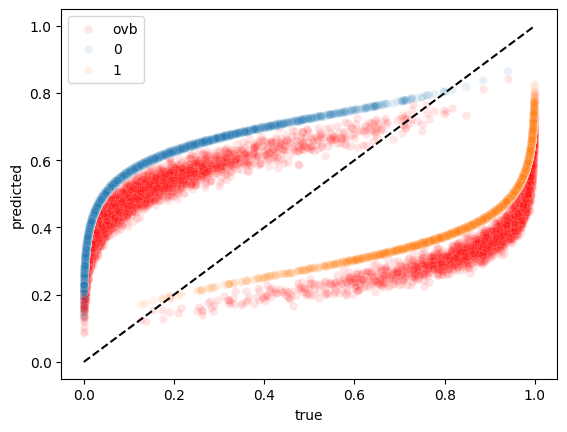

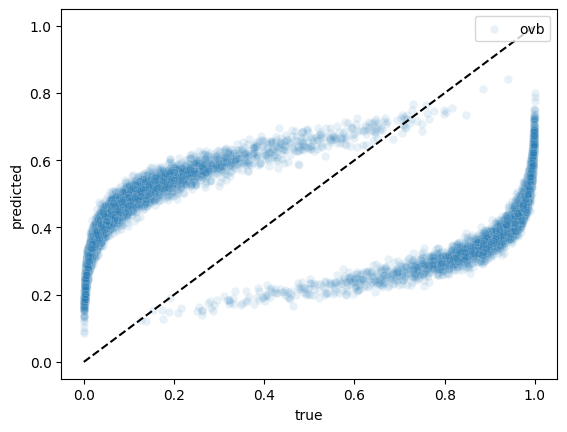

In [76]:
## Logistic version of calibration

print(slopes)

z = df.loc[:,['x1','x2','x3','g'] ]
beta_full = logistic_reg(X,d)
print(beta_full)
L_full = X @ beta_full
p_full = 1-F(L_full)
r_full = L_full + (p_full-d)/( p_full*(1-p_full) )


z = df.loc[:,['x0','x1','x2'] ]
beta_ovb = logistic_reg(z,d)
print(beta_ovb)
L_ovb = z @ beta_ovb
p_ovb = 1-F(L_ovb)
r_ovb = L_ovb + (p_ovb-d)/( p_ovb*(1-p_ovb) )

inf = min([min(p_ovb), min(p_0)])
sup = max([max(p_ovb),max(p_0)])
fig = sns.scatterplot(y=p_ovb,x=p_0,color='red',  label='ovb',alpha=.1)
sns.scatterplot(y=p_full,x=p_0,hue=grp,alpha=.1)
plt.plot((inf,sup),(inf,sup),'k--')
fig.set_ylabel('predicted')
fig.set_xlabel('true')
plt.legend(loc='upper left')
plt.show()

inf = min([min(p_ovb), min(p_0)])
sup = max([max(p_ovb),max(p_0)])
fig = sns.scatterplot(y=p_ovb,x=p_0,label='ovb',alpha=.1)
plt.plot((inf,sup),(inf,sup),'k--')
fig.set_ylabel('predicted')
fig.set_xlabel('true')
plt.legend(loc='upper right')
plt.show()

# inf = min([min(p_ovb), min(p_0)])
# sup = max([max(p_ovb),max(p_0)])
# fig = sns.scatterplot(y=p_full,x=p_0,hue=grp)
# plt.plot((inf,sup),(inf,sup),'k--')
# fig.set_ylabel('predicted')
# fig.set_xlabel('true')
# plt.legend(loc='upper left')
# plt.show()




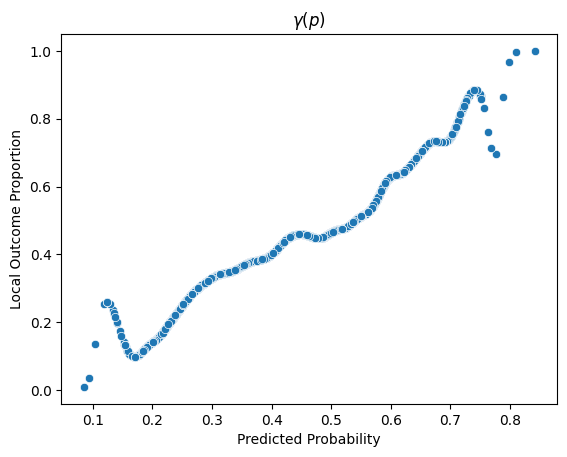

In [77]:
## NP estimation of bias function 

#h_d = 1.06 * np.std(d) * np.pow(N,-.2)
h_ovb = 1.06 * np.std(p_ovb) * np.power(N,-.2) * 1
h_full = 1.06 * np.std(p_full) * np.power(N,-.2)

gamma = []
f_hat = []
for i in range(len(d)):
    p_hat = p_ovb[i]
    kernel = np.exp( -( (p_hat-p_ovb)/h_ovb )**2 ) / (h_ovb * np.sqrt(2*np.pi) )
    den = np.sum( kernel )/len(d)
    num = np.sum( d*kernel )/len(d)
    f_hat.append(den)
    gamma.append( num/den )


# sns.lineplot(x=p_ovb,y=f_hat)
# plt.show()
# sns.kdeplot(p_ovb)
# plt.show()

sns.scatterplot(x=p_ovb,y=gamma)
plt.ylabel('Local Outcome Proportion')
plt.xlabel('Predicted Probability')
plt.title('$\\gamma(p)$')
plt.show()

#sns.scatterplot(x=p_ovb,y=p_0)



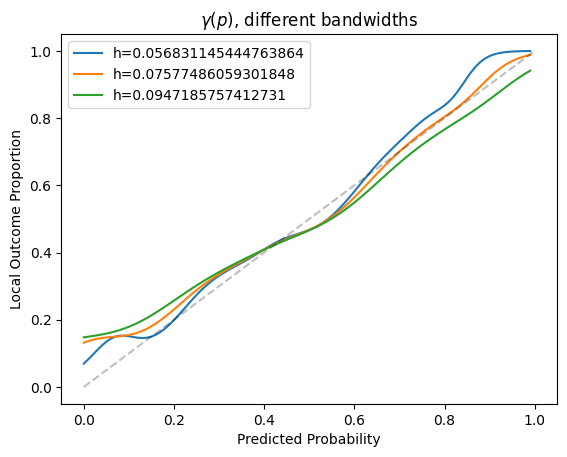

In [78]:
## NP estimation of bias function 

#h_d = 1.06 * np.std(d) * np.pow(N,-.2)
h_ovb = 1.06 * np.std(p_ovb) * np.power(N,-.2) * 1
h_full = 1.06 * np.std(p_full) * np.power(N,-.2)

h_grid = h_ovb * np.array([ 3, 4, 5 ])

x_grid = np.arange(0,1,.01)

# for h in h_grid:
#     gamma = []
#     f_hat = []
#     for i in range(len(d)):
#         p_hat = p_ovb[i]
#         kernel = np.exp( -( (p_hat-p_ovb)/h )**2 ) / (h * np.sqrt(2*np.pi) )
#         den = np.sum( kernel )/len(d)
#         num = np.sum( d*kernel )/len(d)
#         f_hat.append(den)
#         gamma.append( num/den )
#     sns.lineplot(x=p_ovb,y=gamma, label = 'h='+str(h))


for h in h_grid:
    gamma = []
    f_hat = []
    for x in x_grid:
        #p_hat = p_ovb[i]
        kernel = np.exp( -( (x-p_ovb)/h )**2 ) / (h * np.sqrt(2*np.pi) )
        den = np.sum( kernel )/len(d)
        num = np.sum( d*kernel )/len(d)
        f_hat.append(den)
        gamma.append( num/den )
    sns.lineplot(x=x_grid,y=gamma, label = 'h='+str(h))


# sns.lineplot(x=p_ovb,y=gamma)
plt.ylabel('Local Outcome Proportion')
plt.xlabel('Predicted Probability')
plt.title('$\\gamma(p)$, different bandwidths')
#inf = min([min(p_0), min(p_0)])
#sup = max([max(p_0),max(p_0)])
# sns.rugplot(x=p_ovb,alpha=.3)
# sns.rugplot(y=p_0,alpha=.3)
plt.plot((0,1),(0,1),'k--',alpha=.25)
plt.show()

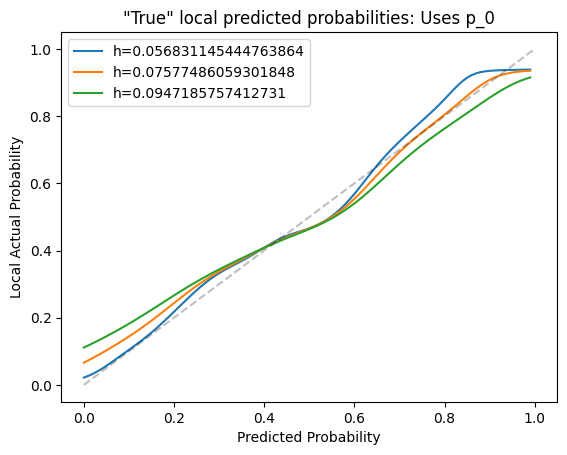

In [79]:



## What's the "true" line?  "E_x[y(x)|\hat{y}(x)]" ?

for h in h_grid:
    gamma = []
    f_hat = []
    for x in x_grid:
        #p_hat = p_ovb[i]
        kernel = np.exp( -( (x-p_ovb)/h )**2 ) / (h * np.sqrt(2*np.pi) )
        den = np.sum( kernel )/len(d)
        num = np.sum( p_0*kernel )/len(d)
        f_hat.append(den)
        gamma.append( num/den )
    sns.lineplot(x=x_grid,y=gamma, label = 'h='+str(h))

plt.xlabel('Predicted Probability')
plt.ylabel('Local Actual Probability')
plt.title('"True" local predicted probabilities: Uses p_0')
plt.plot((0,1),(0,1),'k--',alpha=.25)
plt2 = plt.show()
plt.show()

Text(0.5, 1.0, 'True Bias')

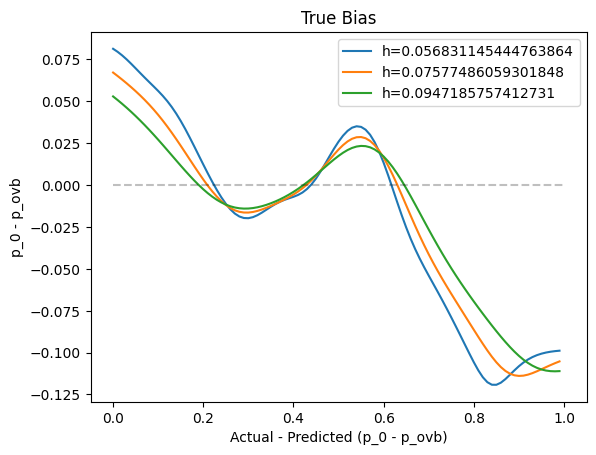

In [80]:

for h in h_grid:
    gamma = []
    f_hat = []
    for x in x_grid:
        #p_hat = p_ovb[i]
        kernel = np.exp( -( (x-p_ovb)/h )**2 ) / (h * np.sqrt(2*np.pi) )
        den = np.sum( kernel )/len(d)
        num = np.sum( (p_ovb-p_0)*kernel )/len(d)
        f_hat.append(den)
        gamma.append( num/den )
    sns.lineplot(x=x_grid,y=gamma, label = 'h='+str(h))
plt.plot((0,1),(0,0),'k--',alpha=.25)
plt.xlabel('Actual - Predicted (p_0 - p_ovb)')
plt.ylabel('p_0 - p_ovb')
plt.title('True Bias')
#plt.show()

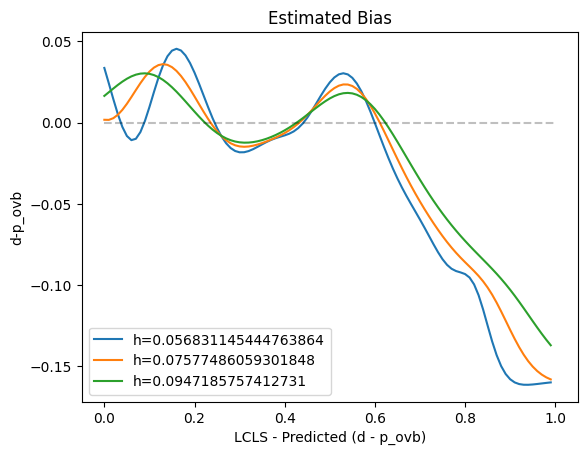

In [81]:

for h in h_grid:
    gamma = []
    f_hat = []
    for x in x_grid:
        #p_hat = p_ovb[i]
        kernel = np.exp( -( (x-p_ovb)/h )**2 ) / (h * np.sqrt(2*np.pi) )
        den = np.sum( kernel )/len(d)
        num = np.sum( (p_ovb-d)*kernel )/len(d)
        f_hat.append(den)
        gamma.append( num/den )
    sns.lineplot(x=x_grid,y=gamma, label = 'h='+str(h))
plt.plot((0,1),(0,0),'k--',alpha=.25)
plt.xlabel('LCLS - Predicted (d - p_ovb)')
plt.ylabel('d-p_ovb')
plt.title('Estimated Bias')
plt3 = plt.show()
plt.show()

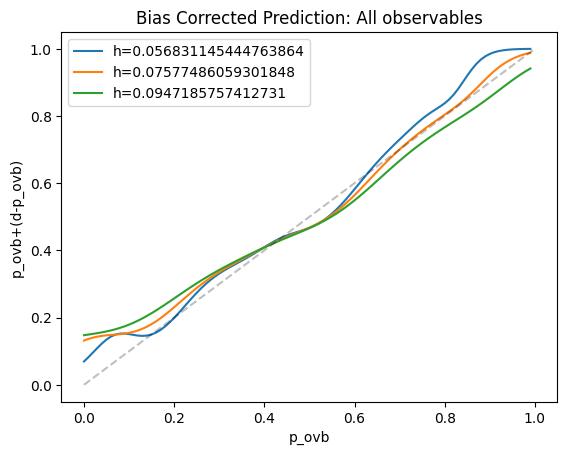

In [82]:

for h in h_grid:
    gamma = []
    f_hat = []
    for x in x_grid:
        #p_hat = p_ovb[i]
        kernel = np.exp( -( (x-p_ovb)/h )**2 ) / (h * np.sqrt(2*np.pi) )
        den = np.sum( kernel )/len(d)
        num = np.sum( (p_ovb + (d-p_ovb))*kernel )/len(d)
        f_hat.append(den)
        gamma.append( num/den )
    sns.lineplot(x=x_grid,y=gamma, label = 'h='+str(h))
plt.plot((0,1),(0,1),'k--',alpha=.25)
plt.xlabel('p_ovb')
plt.ylabel('p_ovb+(d-p_ovb)')
plt.title('Bias Corrected Prediction: All observables')
plt4 = plt.show()
plt.show()

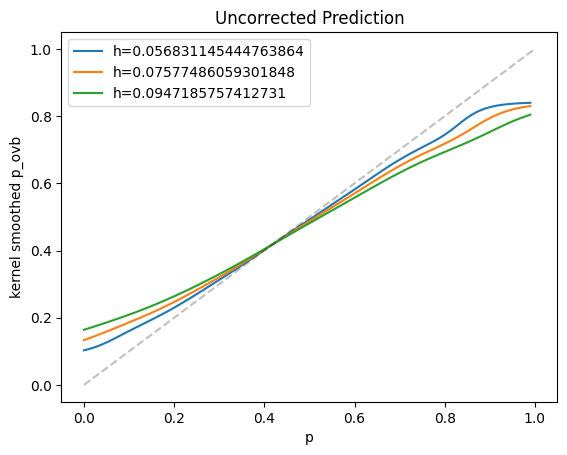

In [83]:

for h in h_grid:
    gamma = []
    f_hat = []
    for x in x_grid:
        #p_hat = p_ovb[i]
        kernel = np.exp( -( (x-p_ovb)/h )**2 ) / (h * np.sqrt(2*np.pi) )
        den = np.sum( kernel )/len(d)
        num = np.sum( p_ovb *kernel )/len(d)
        f_hat.append(den)
        gamma.append( num/den )
    sns.lineplot(x=x_grid,y=gamma, label = 'h='+str(h))
plt.plot((0,1),(0,1),'k--',alpha=.25)
plt.xlabel('p')
plt.ylabel('kernel smoothed p_ovb')
plt.title('Uncorrected Prediction')
plt1 = plt.show()
plt.show()


